# Prevendo Preços com Localização

### Preparação dos dados

In [1]:
pip install -U kaleido --quiet

Importação das bibliotecas

In [2]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
import plotly.io as pio

warnings.simplefilter(action="ignore", category=FutureWarning)

Neste projeto, darei continuidade ao trabalho "Price With Size". Criaremos uma função de wrangle mais complexa, a usaremos para limpar mais dados e construiremos um modelo que considera mais características ao prever o preço de um apartamento.

No projeto "Price With Size", consieramos o tamanho ('surface_covered_in_m2'). Nesse projeto, vamos avaliar como a localização (lat-lon) impacta no preço dos apartamentos.

### Importação

Função wrangle(filepath)

A função wrangle é responsável por importar e limpar o conjunto de dados imobiliários, focando em apartamentos localizados na região da Capital Federal com valor inferior a US$ 400.000.

✅ Etapas executadas:
Importação do arquivo .csv indicado no parâmetro filepath.

Filtragem dos dados para manter apenas:

Imóveis localizados na região "Capital Federal";

Tipo de imóvel igual a “apartment”;

Preço aproximado menor que US$ 400.000.

Remoção de outliers na variável surface_covered_in_m2, mantendo apenas os dados entre o 10º e o 90º percentil.

Separação da coluna lat-lon em duas colunas numéricas: lat (latitude) e lon (longitude), e remoção da coluna original.

O resultado é um DataFrame limpo e pronto para análise exploratória ou modelagem preditiva.

In [3]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split 'lat-lon' column
    df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand=True).astype(float)
    df.drop(columns='lat-lon', inplace=True)


    return df

* Utilizando a função wrangle para criar o DataFrame frame1 com o arquivo 'buenos-aires-real-estate-1.csv'

In [4]:
frame1 = wrangle('/content/buenos-aires-real-estate-1.csv')
print(frame1.info())
frame1.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1343 entries, 4 to 8604
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1343 non-null   object 
 1   property_type               1343 non-null   object 
 2   place_with_parent_names     1343 non-null   object 
 3   price                       1343 non-null   float64
 4   currency                    1343 non-null   object 
 5   price_aprox_local_currency  1343 non-null   float64
 6   price_aprox_usd             1343 non-null   float64
 7   surface_total_in_m2         965 non-null    float64
 8   surface_covered_in_m2       1343 non-null   float64
 9   price_usd_per_m2            927 non-null    float64
 10  price_per_m2                1343 non-null   float64
 11  floor                       379 non-null    float64
 12  rooms                       1078 non-null   float64
 13  expenses                    349 non-nu

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
29,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
40,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
41,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


* Criando outro DataFrame do arquivo 'buenos-aires-real-estate-2.csv' utilizando a função wrangle.

In [5]:
frame2 = wrangle('/content/buenos-aires-real-estate-2.csv')

Realizamos o tratamando dos dados através de uma função porque é muito mais simples de replicar o processo para outros arquivos.

* Agora vamos concatenar os dois DataFrames, frame1 e frame2, em um único DataFrame.

In [6]:
df = pd.concat([frame1, frame2], ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   2658 non-null   object 
 1   property_type               2658 non-null   object 
 2   place_with_parent_names     2658 non-null   object 
 3   price                       2658 non-null   float64
 4   currency                    2658 non-null   object 
 5   price_aprox_local_currency  2658 non-null   float64
 6   price_aprox_usd             2658 non-null   float64
 7   surface_total_in_m2         1898 non-null   float64
 8   surface_covered_in_m2       2658 non-null   float64
 9   price_usd_per_m2            1818 non-null   float64
 10  price_per_m2                2658 non-null   float64
 11  floor                       769 non-null    float64
 12  rooms                       2137 non-null   float64
 13  expenses                    688 n

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
1,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
2,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
3,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
4,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


### Explore

No projeto "Price With Size", construímos um modelo linear simples que previu o preço de um apartamento com base em uma característica, "surface_covered_in_m2". Nesta lição, estamos construindo um modelo de regressão linear múltipla que prevê o preço com base em duas características, "lon" e "lat". Isso significa que nossas visualizações de dados agora precisam comunicar três informações: longitude, latitude e preço. Como podemos representar esses três atributos em uma tela bidimensional?

Uma opção é incorporar cores ao nosso gráfico de dispersão. Por exemplo, no gráfico de dispersão do Mapbox abaixo, a localização de cada ponto representa a latitude e a longitude, e a cor representa o preço.

* Criando um gráfico de dispersão do Mapbox que mostra a localização dos apartamentos em df.

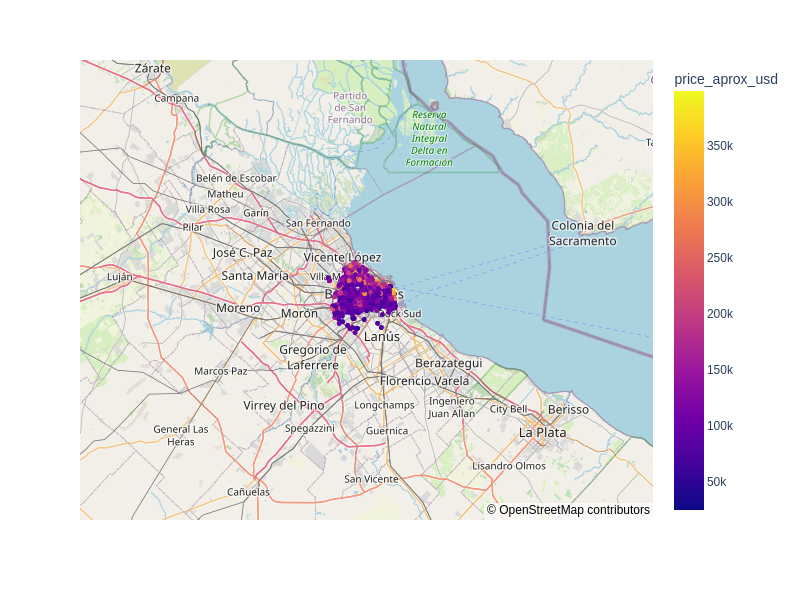

In [12]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='lat',
    lon='lon',
    width=800,  # Width of map
    height=600,  # Height of map
    color='price_aprox_usd',
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")


fig.show(renderer="png")

Outra opção é utilizar um gráfico tridimensional. Com ele podemos plotar longitude, latitude e o preço.

* Criando um gráfico de dispersão 3D, com "lon" no eixo x, "lat" no eixo y e "price_aprox_usd" no eixo z.

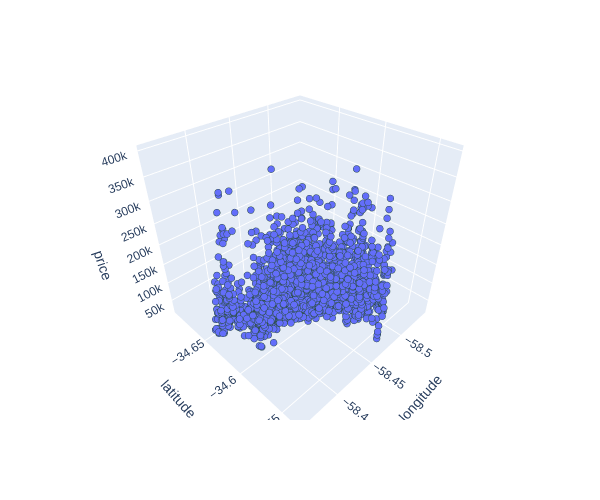

In [8]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x='lon',
    y='lat',
    z='price_aprox_usd',
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show(renderer="png")

Para algumas pessoas, a visualização 3D é difícil de se interpretar. Estamos utilizando uma aqui para nos ajudar a visualizar nosso modelo mais a frente.

### Split

Embora estejamos construindo um modelo diferente, os passos para separar os dados são os mesmo. Vamos separar nossas features (lat e lon) e nosso target(price)

* Criando a matriz X_matrix com as features

In [13]:
features = ["lon", "lat"]
X_train = df[features]

* Criando target vector y_train que será utilizado para treinar nosso modelo.

In [14]:
target = "price_aprox_usd"
y_train = df[target]

### Contruindo o modelo

Baseline

Novamente, precisamos estabelecer uma linha de base que possamos utilizar para avaliar nosso modelo.

* Calculando a média do vetor y_train e assinando na variável y_mean

In [15]:
y_mean = y_train.mean()

* Criando a lista y_pred_baseline que contém o valor de y_man para cada linha de y_train.

In [16]:
y_pred_baseline = [y_mean] * len(y_train)

* Calculando o erro absoluto médio da linha de base para suas previsões em y_pred_baseline em comparação com os alvos reais em y_train.|

In [17]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 134732.97
Baseline MAE: 45422.75


### Iterate

Reserve um momento para rolar para cima até a saída de df.info() e observar os valores na coluna "Non-Null Count". Devido à matemática que ele utiliza, um modelo de regressão linear não consegue lidar com observações onde há valores ausentes. Você vê alguma coluna onde isso seria um problema?

No último projeto, simplesmente descartamos linhas que continham valores NaN, mas isso não é o ideal. Os modelos geralmente têm melhor desempenho quando têm mais dados para treinar, então cada linha é preciosa. Em vez disso, podemos preencher esses valores ausentes usando informações que obtemos de toda a coluna — um processo chamado imputação. Existem muitas estratégias diferentes para imputar valores ausentes, e uma das mais comuns é preencher os valores ausentes com a média da coluna.

Além de preditores como a Regressão Linear, o scikit-learn também possui transformadores que nos ajudam a lidar com problemas como valores ausentes. Vamos ver como um deles funciona e, em seguida, o adicionaremos ao nosso modelo.

*Instanciando o SimpleImputer

In [18]:
imputer = SimpleImputer()

* Inserindo os dados no SimpleImputer

In [19]:
imputer.fit(X_train)

SimpleImputer()

* Usando o imputador para transformar a matriz de características X_train.

In [22]:
XT_train = imputer.transform(X_train)
pd.DataFrame(XT_train, columns=X_train.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     2658 non-null   float64
 1   lat     2658 non-null   float64
dtypes: float64(2)
memory usage: 41.7 KB


Certo! Nossos dados estão livres de valores ausentes e temos uma boa noção de como os preditores funcionam no Scikit-Learn. No entanto, a verdade é que raramente faremos transformações de dados dessa maneira. Por quê? Um modelo pode exigir vários transformadores, e fazer todas essas transformações uma a uma é lento e provavelmente levará a erros. Em vez disso, podemos combinar nosso transformador e preditor em um único objeto chamado pipeline.

* Criando um pipeline chamado model que contenha um transformador SimpleImputer seguido por um preditor LinearRegression.

In [23]:
model = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)

Com nosso pipeline montado, usamos o método fit, que treinará o transformador, transformará os dados e, em seguida, passará os dados transformados para o preditor para treinamento, tudo em uma única etapa. Muito mais fácil!

* Ajustando o modelo aos dados, X_train e y_train.

In [24]:
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [25]:
check_is_fitted(model["linearregression"])

### Evaluate

* Usando o método de previsão do modelo, para criar uma lista de previsões para as observações na nossa matriz de características X_train.

In [26]:
y_pred_training = model.predict(X_train)

* Calculando o erro absoluto médio de treinamento para suas previsões em y_pred_training em comparação com os alvos reais em y_train.

In [27]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 42962.72


Parece que nosso modelo tem um desempenho um pouco melhor do que a linha de base. Isso sugere que latitude e longitude não são preditores tão fortes de preço quanto o tamanho.

### Comunucando os resultados

Vamos dar uma olhada na equação que nosso modelo criou para prever preços com base em latitude e longitude. Precisaremos expandir nossa fórmula para levar em conta ambas as características:

y = b + a1x1 + a2x2

y = Preço

b = Intersecção

a1 = coeficiente 1

x1 = longitude

a2 = coeficiente2

x2 = latitude

In [28]:
intercept = model.named_steps['linearregression'].intercept_.round()
coefficients = model.named_steps['linearregression'].coef_.round()

In [29]:
print(

    f"price = {intercept} + ({coefficients[0]} * longitude) + ({coefficients[1]} * latitude)"
)

price = 38113587.0 + (196709.0 * longitude) + (765467.0 * latitude)


O que esta equação nos diz? À medida que nos movemos para o norte e para o leste, o preço previsto do apartamento aumenta.

No início do notebook, você pode ter imaginado em como representaríamos nosso modelo linear em um gráfico 3D. Se você imaginou que usaríamos um plano, acertou!

* O código abaixo cria um gráfico de dispersão 3D, com "lon" no eixo x, "lat" no eixo y e "price_aprox_usd" no eixo z.

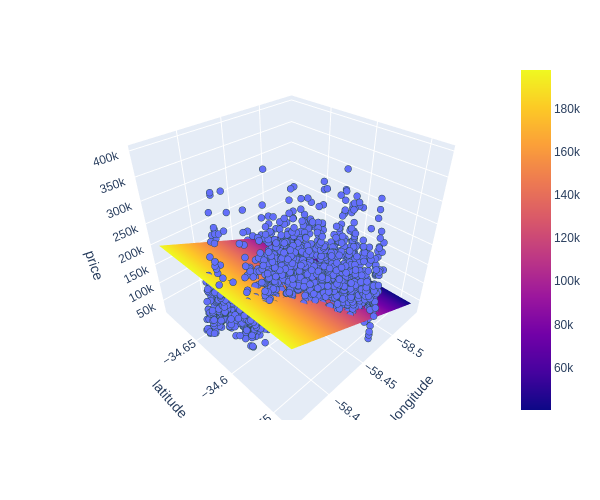

In [31]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x='lon',
    y='lat',
    z="price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Create x and y coordinates for model representation
x_plane = np.linspace(df["lon"].min(), df["lon"].max(), 10)
y_plane = np.linspace(df["lat"].min(), df["lat"].max(), 10)
xx, yy = np.meshgrid(x_plane, y_plane)

# Use model to predict z coordinates
z_plane = model.predict(pd.DataFrame({"lon": x_plane, "lat": y_plane}))
zz = np.tile(z_plane, (10, 1))

# Add plane to figure
fig.add_trace(go.Surface(x=xx, y=yy, z=zz))

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show(renderer='png')